In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import os
import re




In [3]:
current_dir = os.getcwd()


#just a quick verif to check whether the file exist in the current directory and whether the current directory itself exist
if len(current_dir) != 0 and re.search(r"^C:\\",current_dir):
    print("Directory exist\n")
else:
    raise ValueError("Directory empty \n")

print(current_dir)

found = False
for i in os.listdir(current_dir):
    if i == "listings.csv":
        print("CSV file existing\n")
        found = True
        data = pd.read_csv("listings.csv")
        break

if not found:
    print("csv missing\n")
    exit(-1)

Directory exist

C:\Users\Yuan Shao\Desktop\multimodal_pro
CSV file existing



Just merely meant to tinker with the os lib

In [4]:
print(data.head(15),end="\n")
#print(data.columns,end="\n")
col = data.columns
filt = col.str.contains(r"review",regex=True)
data_filt = data.loc[:,filt].any(axis=1)
print(data.loc[data_filt].head(3),end="\n")

#let us find out about the host
print(data.columns)


         id                           listing_url       scrape_id  \
0   2719440  https://www.airbnb.com/rooms/2719440  20250912034503   
1   2721397  https://www.airbnb.com/rooms/2721397  20250912034503   
2   2726092  https://www.airbnb.com/rooms/2726092  20250912034503   
3   2726327  https://www.airbnb.com/rooms/2726327  20250912034503   
4   2727929  https://www.airbnb.com/rooms/2727929  20250912034503   
5   2729247  https://www.airbnb.com/rooms/2729247  20250912034503   
6   2732500  https://www.airbnb.com/rooms/2732500  20250912034503   
7   2733196  https://www.airbnb.com/rooms/2733196  20250912034503   
8   2735222  https://www.airbnb.com/rooms/2735222  20250912034503   
9   2738129  https://www.airbnb.com/rooms/2738129  20250912034503   
10  2808483  https://www.airbnb.com/rooms/2808483  20250912034503   
11  2808778  https://www.airbnb.com/rooms/2808778  20250912034503   
12  2810629  https://www.airbnb.com/rooms/2810629  20250912034503   
13  2813840  https://www.airbnb.co

Here we have 2 kind of data, structed (quantitative/qualitative) and unstructured(text) 

Hypothesis, we might have to resort to use models applied to numerics/categorical variables thus text mining(TF-IDF so on and so forth) 

***NOW LET US FOCUS ON THE SUPERHOST***

host_is_superhost
0.0    62568
1.0    16972
NaN     2313
Name: count, dtype: int64


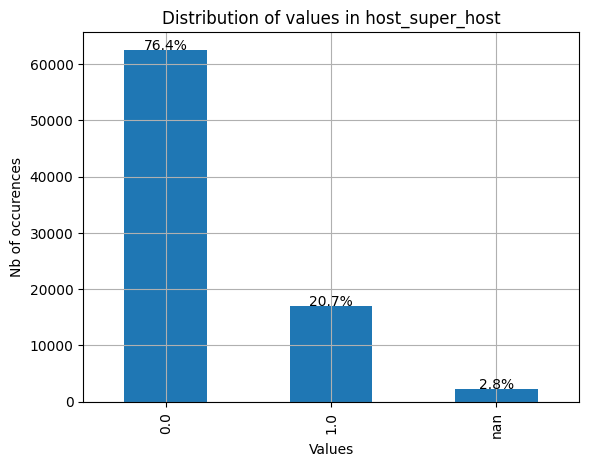

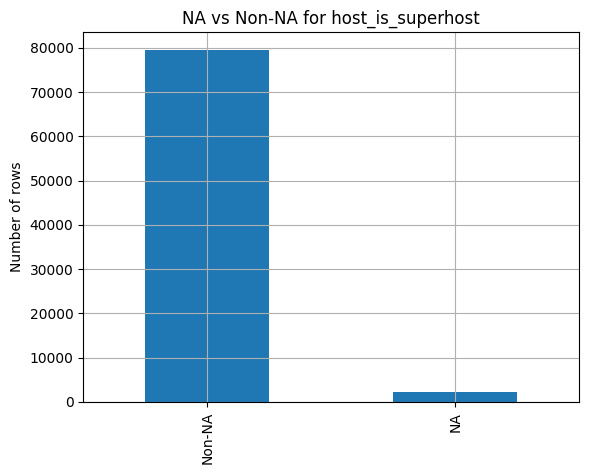

                 id     scrape_id       host_id  host_is_superhost  \
count  8.185300e+04  8.185300e+04  8.185300e+04       79540.000000   
mean   6.474769e+17  2.025091e+13  1.881639e+08           0.213377   
std    5.533184e+17  0.000000e+00  2.105173e+08           0.409694   
min    3.109000e+03  2.025091e+13  2.626000e+03           0.000000   
25%    3.124670e+07  2.025091e+13  1.932200e+07           0.000000   
50%    8.417510e+17  2.025091e+13  7.426650e+07           0.000000   
75%    1.130166e+18  2.025091e+13  3.445411e+08           0.000000   
max    1.482029e+18  2.025091e+13  7.171757e+08           1.000000   

       host_listings_count  host_total_listings_count  \
count         81833.000000               81833.000000   
mean             30.160217                  39.745164   
std             116.081728                 155.466214   
min               0.000000                   0.000000   
25%               1.000000                   1.000000   
50%               1.000000 

In [5]:
data["host_is_superhost"] = data["host_is_superhost"].map({"f":0,"t":1})

distrib = data["host_is_superhost"].value_counts(dropna=False)

print(distrib)

#distribution to explore and understand more
distrib.plot(kind="bar")
plt.title("Distribution of values in host_super_host")
perc = (lambda x: (x / distrib.sum())*100)

for i,v in enumerate(distrib):
    
    plt.text(i,v,f"{perc(v):.1f}%",ha="center")
plt.xlabel("Values")
plt.ylabel("Nb of occurences")
plt.grid(True)
plt.show()

na_mask = data["host_is_superhost"].isna()

na_counts = na_mask.value_counts()
na_counts.index = ["Non-NA", "NA"]
na_counts.plot(kind="bar")
plt.title("NA vs Non-NA for host_is_superhost")
plt.ylabel("Number of rows")
plt.grid(True)
plt.show()


print(data.describe())
print(f"\n{data.dtypes.value_counts()}")

#let us retrieve numerical variables
target = "host_is_superhost"

num_col = data.select_dtypes(include=["number"]).columns.tolist()
num_col = [c for c in num_col if c != target]

quali_col = data.select_dtypes(exclude=["number"]).columns.tolist()

print(data[num_col].describe().T) #Here certain values may be counted as NAN because they are not numerically formated


***We now notice that columns ids are unique and not relevant for predictions, therefore we may remove EM***

In [6]:
data.shape
#data.drop(columns=["id","scrape_id","host_id"],axis=1,inplace=True)
print("After removal\n")
data.shape

After removal



(81853, 79)

,listing_url,last_scraped,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,https://www.airbnb.com/rooms/2719440,2025-09-12,previous scrape,Nice flat close to Montparnasse,This beautiful apartment is very well located ...,"The neighborhood is very nice, feel free to sh...",https://a0.muscache.com/pictures/295786e7-116c...,https://www.airbnb.com/users/show/13915159,Thibaut,2014-04-05,...,4.94,4.86,4.73,7510702406383,f,1,1,0,0,0.57
1,https://www.airbnb.com/rooms/2721397,2025-09-12,previous scrape,"Marais - Charming loft, river view","In the heart of historical Paris le Marais, gr...",Le Marais is the heart of Paris. Few years ago...,https://a0.muscache.com/pictures/de55313f-9b4b...,https://www.airbnb.com/users/show/13925876,Cecilie,2014-04-05,...,4.95,4.91,4.85,7510400455677,f,1,1,0,0,0.66
2,https://www.airbnb.com/rooms/2726092,2025-09-12,previous scrape,Superbe 2 pièces idéalement placé,A stone's throw from Parc Monceau and the Arc ...,Quiet and residential area... Close to the Bat...,https://a0.muscache.com/pictures/6d6c4bc6-9473...,https://www.airbnb.com/users/show/13612373,Clemence,2014-03-27,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,https://www.airbnb.com/rooms/2726327,2025-09-12,previous scrape,"Cozy place, Sacré Coeur Montmartre in the SoPi",Cozy apartment close to everything.<br />Perfe...,One of the most trendy corners of the capital ...,https://a0.muscache.com/pictures/6b569382-aed7...,https://www.airbnb.com/users/show/7483725,Hélène,2013-07-14,...,4.97,4.92,4.67,7510901014972,f,1,1,0,0,0.72
4,https://www.airbnb.com/rooms/2727929,2025-09-12,previous scrape,Appartement d'architecte - Montmartre,"Our apartment, refurbished by an architect in ...",The apartment is in the heart of Paris's 18th ...,https://a0.muscache.com/pictures/miso/Hosting-...,https://www.airbnb.com/users/show/13960346,Paul,2014-04-06,...,5.00,4.57,5.00,7511808333770,f,1,1,0,0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81848,https://www.airbnb.com/rooms/1481754230424845668,2025-09-15,previous scrape,Apt a/c 1BR/2P - Saint-Lazare/Les Champs Elysée,📌 Checkmyguest offers you a charming and spaci...,🏘️ The 8th arrondissement of Paris is one of t...,https://a0.muscache.com/pictures/prohost-api/H...,https://www.airbnb.com/users/show/524851930,Joffrey Sally,2023-07-10,...,5.00,5.00,5.00,7510815621419,t,184,184,0,0,2.00
81849,https://www.airbnb.com/rooms/1481771421372168466,2025-09-15,previous scrape,Superbe duplex avec terrasse face Tour Eiffel,The Konciergerie is proud to present this char...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,https://www.airbnb.com/users/show/563248085,Eliav,2024-02-21,...,NaN,NaN,NaN,"Available with a mobility lease only (""bail mo...",t,76,76,0,0,NaN
81850,https://www.airbnb.com/rooms/1481789891762355898,2025-09-15,previous scrape,Cozy studio - 2P - Place des Vosges/Marais,Checkmyguest offers you an exceptional 24 m² s...,"Romantic, festive and trendy, the Marais distr...",https://a0.muscache.com/pictures/prohost-api/H...,https://www.airbnb.com/users/show/691591816,Michael David,2025-04-23,...,4.00,5.00,4.00,7510406440280,t,3,3,0,0,1.00
81851,https://www.airbnb.com/rooms/1481814132906153972,2025-09-15,previous scrape,Appt entier 35m2 proche Montmartre,Quiet 35 m2 apartment in the heart of Paris.<b...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,https://www.airbnb.com/users/show/35944108,Lucie,2015-06-16,...,NaN,NaN,NaN,NaN,f,2,1,1,0,NaN


***We notice that urls are irelevant in our case, so they are to be removed as well***

In [7]:
url_list : list = [x for x in data.columns if re.search("url",x)]
print(url_list)

['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']


In [8]:
data.drop(columns=url_list,axis=1,inplace=True)

In [9]:
data.shape[1]

74

***looks like we got some metadata as well such as scraping columns and source***

In [10]:
scrap_l : list = [cl for cl in data.columns if re.search("scraped",cl) or re.search("source",cl)]
print(scrap_l)

['last_scraped', 'source', 'calendar_last_scraped']


In [11]:
data.drop(columns=scrap_l,axis=1,inplace=True)

In [12]:
data.shape

(81853, 71)

***I had an idea, I thought perhaps I should check for all columns containing NA and sort them by quantity of NAN VALUES***

In [13]:
na_ratio = data.isna().mean().sort_values(ascending=False)

In [14]:
na_ratio.head(20)

neighbourhood_group_cleansed    1.000000
estimated_revenue_l365d         1.000000
bathrooms                       1.000000
calendar_updated                1.000000
beds                            1.000000
price                           1.000000
host_neighbourhood              0.657948
host_about                      0.554042
neighbourhood                   0.516206
neighborhood_overview           0.516206
host_response_rate              0.393449
host_response_time              0.393449
host_acceptance_rate            0.319231
review_scores_value             0.219638
review_scores_checkin           0.219638
review_scores_location          0.219625
review_scores_accuracy          0.219552
review_scores_communication     0.219528
review_scores_cleanliness       0.219515
review_scores_rating            0.219418
dtype: float64

***We do have interesting informations here, as we can see somecolumns have 100% NANS values, therefore irrelevant informations for our predictions***

In [15]:
print(type(na_ratio))

<class 'pandas.core.series.Series'>


In [16]:
na_ratio = na_ratio[na_ratio > 0.8].index.tolist()
na_ratio

['neighbourhood_group_cleansed',
 'estimated_revenue_l365d',
 'bathrooms',
 'calendar_updated',
 'beds',
 'price']

***Surprised to notice that the price***

In [17]:
print(data["price"])
#Price contains no values, therefore it is a useless numerical value

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
81848   NaN
81849   NaN
81850   NaN
81851   NaN
81852   NaN
Name: price, Length: 81853, dtype: float64


In [18]:
data.drop(columns=na_ratio,axis=1,inplace=True)

In [19]:
data.shape

(81853, 65)

In [20]:
na_ratio = data.isna().mean().sort_values(ascending=False)
na_ratio

host_neighbourhood        0.657948
host_about                0.554042
neighbourhood             0.516206
neighborhood_overview     0.516206
host_response_rate        0.393449
                            ...   
availability_30           0.000000
maximum_nights            0.000000
maximum_nights_avg_ntm    0.000000
minimum_nights_avg_ntm    0.000000
id                        0.000000
Length: 65, dtype: float64

In [21]:
data.columns

Index(['id', 'scrape_id', 'name', 'description', 'neighborhood_overview',
       'host_id', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'amenities',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'avail

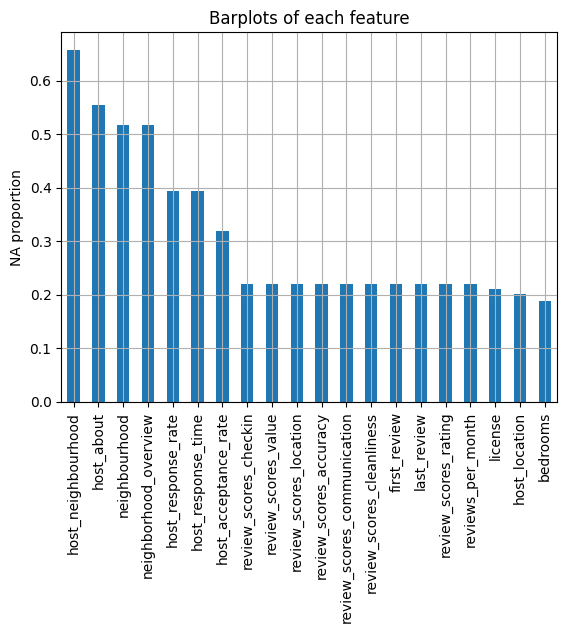

In [22]:
#Let's visualize our data
na_ratio.head(20).plot(kind="bar")
plt.ylabel("NA proportion")
plt.grid(True)
plt.title("Barplots of each feature")
plt.show()

#New Idea, ***observing numerical features to check whether we have correlations, perhaps a PCA could help us if we do see some***

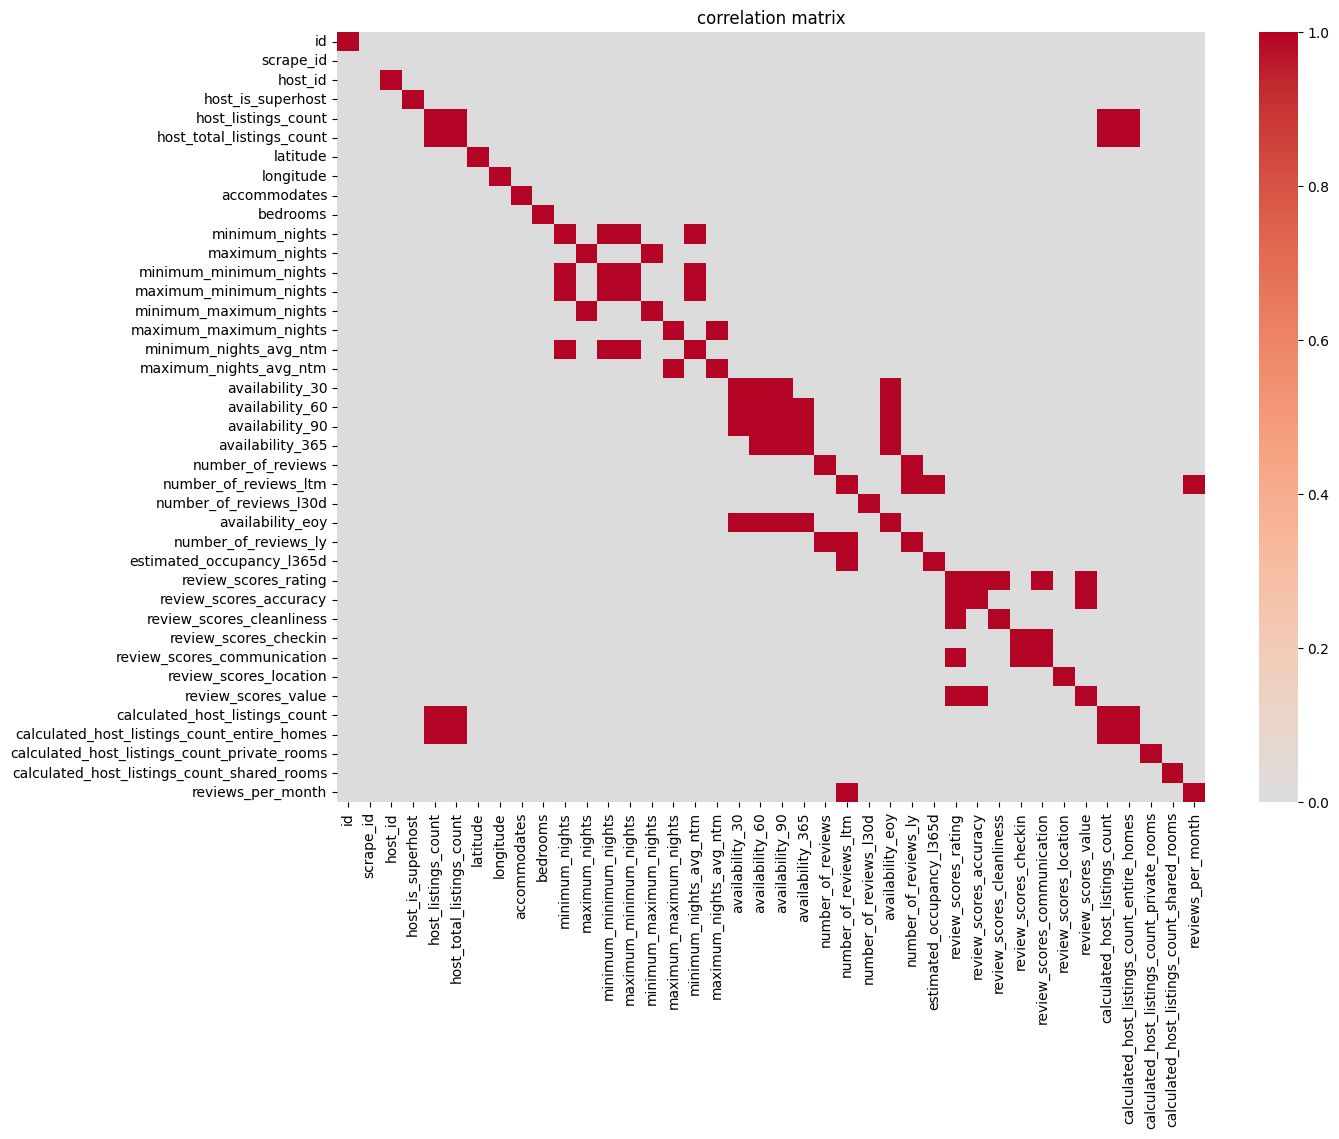

In [24]:
num = data.select_dtypes(include="number").columns
corr = data[num].corr()
strong_cor = corr > 0.7
import seaborn as sns
plt.figure(figsize=(14,10))
sns.heatmap(strong_cor,cmap="coolwarm",center=0)
plt.title("correlation matrix")
plt.show()

***The heatmap(correlation matrix) shows something interesting, several groups of variables are strongly correlated(housing availability, activity and quality)
Furthermore the rating of profesionnalism of hosts. This structure suggests the existence of commun dimmensions and colinearity between columns. Which indicates the possibility of using exploratory
techniques, such as PCA on those quantitative variables.***